# Assignment 7.1 - Viola & Jones 

Welcome to the assignment for week 7.

#### Please state both names of your group members here:
S M Shameem Ahmed Khan and Rashid Harvey

---

## Grading Info/Details - Assignment 7.1:

The assignment will be graded semi-automatically, which means that your code will be tested against a set of predefined test cases and qualitatively assessed by a human. This will speed up the grading process for us.

* For passing the test scripts: 
    - Please make sure to **NOT** alter predefined class or function names, as this would lead to failing of the test scripts.
    - Please do **NOT** rename the files before uploading to the Whiteboard!

* **(RESULT)** tags indicate checkpoints that will be specifically assessed by a human.

* You will pass the assignment if you pass the majority of test cases and we can at least confirm effort regarding the **(RESULT)**-tagged checkpoints per task.

---

## Task 7.1.1: Rectangular Features

* Implement the construction of all 2-rect features (horizontal and vertical) within a given window (like the 24x24 px window from the paper)
* How many exist? **(RESULT)** 
* Display three of these overlaid onto an image of a face. **(RESULT)**

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, data
from tqdm.notebook import tqdm

# In case you don't have scikit-image installed, uncomment the following line:
# !pip install scikit-image

In [6]:
size = 24
orientations = ['vertical', 'horizontal']

# feature: orientation, width, height, x, y, parity, threshold
features = []

for orientation in orientations:
    for width in range(2, size // 2 + 1, 2):
        for height in range(2, size // 2 + 1, 2):
            for x in range(size - width):
                for y in range(size - height):
                    for parity in [1, -1]:
                        for threshold in range(5, 100, 5):
                            features.append((orientation, width, height, x, y, parity, threshold))

# number of features
num_features = len(features)
print(f"Total number of features: {num_features}")

Total number of features: 790704


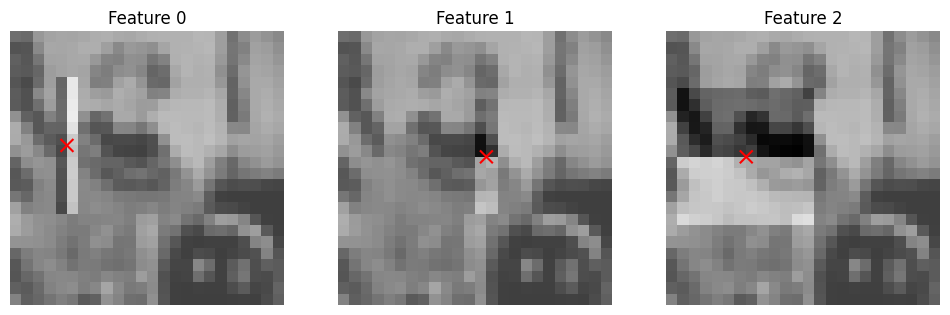

In [7]:
def show_feature(feature):
    feature_image = np.zeros((size, size))
    
    if orientation == 'vertical':
        feature_image[y:y+height, x:x+width//2] = parity * 255
        feature_image[y:y+height, x+width//2:x+width] = -parity * 255
    else:  # horizontal
        feature_image[y:y+height//2, x:x+width] = parity * 255
        feature_image[y+height//2:y+height, x:x+width] = -parity * 255
    
    return feature_image

# choose three at random
from random import sample
chosen_features = sample(features, 3)

astronaut = color.rgb2gray(data.astronaut())
astronaut_resized = transform.resize(astronaut, (size, size))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, (ax, feature) in enumerate(zip(axes, chosen_features)):
    orientation, width, height, x, y, parity, threshold = feature
    
    ax.imshow(astronaut_resized, cmap='gray')
    ax.imshow(show_feature(feature), cmap='gray', alpha=0.5)
    # red cross
    cx, cy = (x + width // 2, y + height // 2)
    ax.plot([cx-1, cx], [cy-1, cy], 'r-')
    ax.plot([cx-1, cx], [cy, cy-1], 'r-')

    ax.set_title(f"Feature {i}")
    ax.axis('off')

## Task 7.1.2: Integral Image

* Implement a function that computes the integral image of a given input image. Display the integral image for an input of you choice **(RESULT)**. 
* Compare it to the output of skimage's integral_image() function. **(RESULT)**

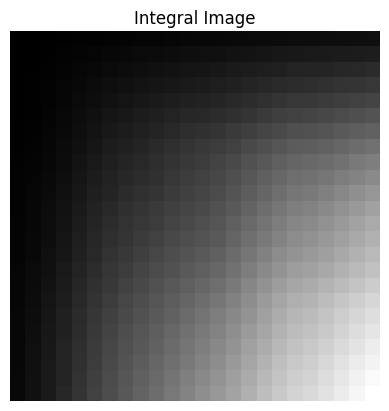

In [8]:
def integral_image(image):
    ii = np.cumsum(np.cumsum(image, axis=0), axis=1)
    return ii


ii = integral_image(astronaut_resized)
# renormalize
ii /= ii[-1, -1]*256

plt.imshow(ii, cmap='gray')
plt.title("Integral Image")
plt.axis('off')
plt.show()

In [9]:
# Comparison
from skimage.transform import integral_image as sk_integral_image

ii_sk = sk_integral_image(astronaut_resized)
ii = integral_image(astronaut_resized)

difference = np.abs(ii - ii_sk)
assert difference.sum() < 1e-10
print(difference.sum())

0.0


## Task 7.1.3: One Weak Classifier

* Implement a weak classifier that uses a single rectangular feature to classify an image as face/non-face. The classifier should take as input the integral image, the feature type, position, size, and threshold. It should output 1 for face, and 0 for non-face predictions. **(RESULT)**
* Test your weak classifier on an example image of your choice. **(RESULT)**

Suggestion: Use one cifar image as non-face and one tinyface image as face.

In [10]:
# Get TinyFace using for example gdown
# !pip install gdown
# !gdown 1xTZc7lNmWN33ECO2AKH6FycGdiqIK7W0
# !unzip tinyface.zip
# !rm tinyface.zip

In [11]:
# Prepare tinyface data
import os
import shutil
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

def move_files_to_parent(parent_dir):
    for root, dirs, files in os.walk(parent_dir, topdown=False):
        # Move files in subdirectories to the parent directory
        for file in files:
            src = os.path.join(root, file)
            dst = os.path.join(parent_dir, file)
            shutil.move(src, dst)
        
        # Remove empty subdirectories
        for directory in dirs:
            subdir = os.path.join(root, directory)
            if not os.listdir(subdir):  # Check if the directory is empty
                os.rmdir(subdir)

path = 'tinyface/Training_Set/'
move_files_to_parent(path)

In [12]:
class TinyFace(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory with all images.
            transform (callable, optional): Optional transform to apply to the images.
        """
        self.image_dir = img_dir
        self.image_filenames = [
            f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the image to retrieve.
        
        Returns:
            image: Transformed image.
            label: Label (optional, could be derived from filenames if needed).
        """
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")  # Ensure 3-channel RGB
        if self.transform:
            image = self.transform(image)
        label = 1
        return (image, label)

# Define the transforms for preprocessing
transform = transforms.Compose([
    transforms.Resize((24, 24)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Create the dataset
tinyface_dataset = TinyFace(img_dir='tinyface/Training_Set', transform=transform)

# Access a single sample
image, label = tinyface_dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")
print(len(tinyface_dataset))

Image shape: torch.Size([1, 24, 24]), Label: 1
7804


In [13]:
# Face Data samples done
# Now loading CIFAR-10 dataset as non-face data and prepping it similarly

In [14]:
# Load CIFAR-10 dataset as non-face data

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((24, 24)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

cifar10_train = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

cifar10_test = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Setting all targets to 0 (non-face)
cifar10_train.targets = [0] * len(cifar10_train)
cifar10_test.targets = [0] * len(cifar10_test)

# Access samples
image, label = cifar10_train[0]
print(f"Image shape: {image.shape}, Label: {label}")

Image shape: torch.Size([1, 24, 24]), Label: 0


In [25]:
from typing import Literal


class WeakFeature:
    def __init__(self, orientation: Literal['horizontal', 'vertical'], width: int, height: int, x: int, y: int, parity: int, threshold: float):
        self.orientation = orientation
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.parity = parity
        self.threshold = threshold

    def predict(self, integral_image):
        x, y, w, h = self.x, self.y, self.width, self.height
        if self.orientation == 'vertical':
            left = self.sum_region(integral_image, x, y, w // 2, h)
            right = self.sum_region(integral_image, x + w // 2, y, w // 2, h)
            feature_value = left - right
        else:  # horizontal
            top = self.sum_region(integral_image, x, y, w, h // 2)
            bottom = self.sum_region(integral_image, x, y + h // 2, w, h // 2)
            feature_value = top - bottom
        
        prediction = int(self.parity * feature_value < self.parity * self.threshold)
        return prediction
    
    def sum_region(self, integral_image, x, y, w, h):
        A = integral_image[y-1, x-1] if x > 0 and y > 0 else 0
        B = integral_image[y-1, x + w - 1] if y > 0 else 0
        C = integral_image[y + h - 1, x - 1] if x > 0 else 0
        D = integral_image[y + h - 1, x + w - 1]
        return D - B - C + A

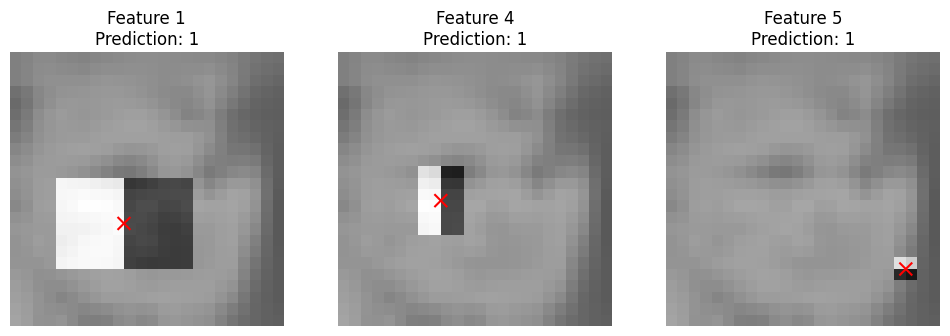

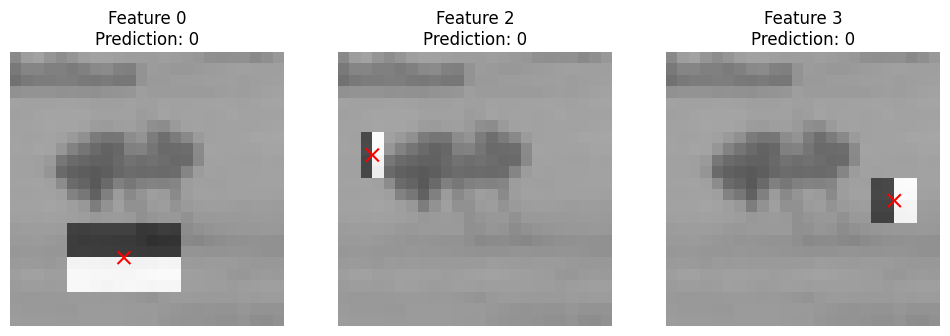

In [32]:
face = tinyface_dataset[0][0][0]
ii_face = integral_image(face)

no_face = cifar10_train[42][0][0]
ii_no_face = integral_image(no_face)

random_features = features.copy()
np.random.shuffle(random_features)

for j, (img, ii) in enumerate([(face, ii_face), (no_face, ii_no_face)]):

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    c = 0

    for i, feature in enumerate(random_features):
        orientation, width, height, x, y, parity, threshold = feature
        weak_feature = WeakFeature(orientation, width, height, x, y, parity, threshold)
        prediction = weak_feature.predict(ii)

        if prediction == j:
            continue

        ax = axes[c]
        
        ax.imshow(img, cmap='gray')
        ax.imshow(show_feature(feature), cmap='gray', alpha=0.7)
        # red cross
        cx, cy = (x + width // 2, y + height // 2)
        ax.plot([cx-1, cx], [cy-1, cy], 'r-')
        ax.plot([cx-1, cx], [cy, cy-1], 'r-')

        ax.set_title(f"Feature {i}\nPrediction: {prediction}")
        
        ax.axis('off')
        c += 1
        if c >= 3:
            break

    # fig.show()

## Task 7.1.4: AdaBoosting (BONUS)

* Implement the AdaBoost algorithm as outlined in the paper (https://www.face-rec.org/algorithms/Boosting-Ensemble/16981346.pdf).
* Train a 20-feature classifier using these datasets:
    - TinyFace for low resolution face images: https://qmul-tinyface.github.io/
    - CIFAR10 for negative samples: https://www.cs.toronto.edu/~kriz/cifar.html
* Test your classifier and report the results for different thresholds **(RESULTS)**

Suggestion: Use torch.utils.data.ConcatDataset to finalize the dataset. If you are more comfortable with numpy or another framework feel free to convert the data accordingly. <br><br>
Example conversion from torch.tensor to numpy: `numpy_array = tensor.numpy()`

In [36]:
from torch.utils.data import ConcatDataset

train_dataset = ConcatDataset([tinyface_dataset, cifar10_train])
test_dataset = ConcatDataset([tinyface_dataset, cifar10_test])

In [41]:
class AdaBoost:
    def __init__(self, threshold, num_classifiers: int = 20):
        self.threshold = threshold
        self.num_classifiers = num_classifiers
        self.classifiers = []
        self.alphas = []
    
    def fit(self, dataset):
        omega = np.ones(len(dataset)) / len(dataset)
        alpha = np.zeros(len(features))

        integral_images = [
            integral_image(dataset[i][0][0]) for i in range(len(dataset))
        ]

        labels = np.array([dataset[i][1] for i in range(len(dataset))])

        # Train weak classifiers
        for m, f in enumerate(features):
            orientation, width, height, x, y, parity, threshold = f
            weak_feature = WeakFeature(orientation, width, height, x, y, parity, threshold)
            predictions = np.zeros(len(dataset))
            for i, ii in enumerate(integral_images):
                predictions[i] = weak_feature.predict(ii)
            error = predictions != labels
            # sum weighted error (E_m)
            total_error = np.sum(omega * error)
            alpha[m] = np.log((1 - total_error) / (total_error + 1e-10))
            # (1,0) -> (1,-1)
            omega = omega * np.exp(alpha[m] * ((error*2) -1))

        # Find num_classifiers best weak classifiers
        best_indices = np.argsort(alpha)[-self.num_classifiers:]
        self.classifiers = [features[i] for i in best_indices]
        self.alphas = alpha[best_indices]

    def predict(self, integral_image):
        return round(sum(
            alpha * WeakFeature(*feature).predict(integral_image)
            for feature, alpha in zip(self.classifiers, self.alphas)
        ) / sum(self.alphas)) >= self.threshold

In [ ]:
for threshold in [0.3, 0.5, 0.7]:
    ada = AdaBoost(threshold=threshold)
    ada.fit(train_dataset)

    # Evaluate on test set
    correct = 0
    for i in range(len(test_dataset)):
        img = test_dataset[i][0][0]
        ii = integral_image(img)
        prediction = ada.predict(ii)
        if prediction == test_dataset[i][1]:
            correct += 1
    accuracy = correct / len(test_dataset)
    print(f"Threshold: {threshold}, Test Accuracy: {accuracy:.4f}")

## Congratz, you made it! :)